In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'data/EPHPM JDULIO 2025 ETIQUETAS.csv')

In [4]:
import pandas as pd
import numpy as np

def etl_hogar(df, target="ymophg"):
    df = df.copy()

    # ID de hogar
    hogar_id = "HOGAR"

    # Variables persona → agregación
    persona_vars = {
        "EDAD": ["mean", "max"],
        "anosest": ["mean"],
        "SEXO": ["mean"]  # proporción de hombres (1=Hombre, 0=Mujer)
    }

    # Variables propias del hogar (se toma la primera)
    hogar_vars = [
        "TOTPER",
        "Totpervi",
        "V01","V02","V03","V04","V05","V06","V07","V08","V09",
        target
    ]

    # Eliminar columnas de texto libre
    df = df.loc[:, ~df.columns.str.contains("OTRO|ESP", regex=True)]

    # Codificar SEXO a numérico (1=Hombre, 0=Mujer)
    df['SEXO'] = df['SEXO'].map({'Hombre': 1, 'Mujer': 0})
    
    # Asegurar target numérico (valores vacíos/espacios se convierten a NaN)
    df[target] = pd.to_numeric(df[target].replace('', np.nan), errors="coerce")
    
    # Convertir variables persona a numérico
    df['EDAD'] = pd.to_numeric(df['EDAD'], errors="coerce")
    df['anosest'] = pd.to_numeric(df['anosest'], errors="coerce")

    # Agregación de variables persona
    agg_dict = {}
    for var, funcs in persona_vars.items():
        for f in funcs:
            agg_dict[f"{var}_{f}"] = (var, f)

    persona_agg = (
        df.groupby(hogar_id)
          .agg(**agg_dict)
          .reset_index()
    )

    # Base de hogar - tomar el primer valor no nulo de ymophg por hogar
    hogar_base = (
        df.groupby(hogar_id)[hogar_vars]
          .first()
          .reset_index()
    )

    # Merge final
    hogar_df = hogar_base.merge(
        persona_agg,
        on=hogar_id,
        how="left"
    )

    # Limpieza final - eliminar hogares sin target
    hogar_df = hogar_df.dropna(subset=[target])
    hogar_df = hogar_df.drop(columns=[hogar_id])

    # One-hot encoding
    hogar_df = pd.get_dummies(hogar_df, drop_first=True)

    return hogar_df


In [5]:
df_clean = etl_hogar(df.copy())
df_clean.head()

,TOTPER,Totpervi,ymophg,EDAD_mean,EDAD_max,anosest_mean,SEXO_mean,V01_Casa individual,V01_Cuarto en meson o cuarteria,"V02_Ladrillo, piedra o bloque",...,V09_3,V09_5,V09_6,V09_1,V09_2,V09_3,V09_4,V09_5,V09_6,V09_8
0,5,5,24000.0,34.531987,86,8.297101,0.444444,True,False,True,...,False,False,False,False,False,False,False,False,True,False
1,3,3,55000.0,31.755274,92,8.091787,0.426160,True,False,True,...,False,False,False,False,False,False,True,False,False,False
2,5,5,14000.0,31.696970,84,6.567901,0.454545,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,4,4,7200.0,32.611111,84,7.609756,0.425926,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,3,3,48400.0,29.776382,99,5.510497,0.494137,True,False,True,...,False,False,False,False,True,False,False,False,False,False


In [6]:
import pandas as pd
import numpy as np

def etl_depto(df):
    df = df.copy()

    # Variables numéricas clave
    num_vars = ["ymophg", "anosest", "TOTPER", "EDAD"]
    for col in num_vars:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # -----------------------------
    # Variables binarias / flags
    # -----------------------------
    # Ocupado (1 = ocupado, 0 = no ocupado)
    df["ocupado"] = df["CONDACT"].str.contains("Ocupados", case=False, na=False).astype(int)

    # Pobreza (1 = pobre)
    df["pobre"] = df["Pobreza"].isin(["Pobres", "Extrema"]).astype(int)

    # NBI (1 = tiene al menos 1 NBI)
    df["nbi_flag"] = ~df["nbi"].str.contains("sin", case=False, na=False)
    df["nbi_flag"] = df["nbi_flag"].astype(int)

    depto_df = (
        df.groupby("DEPTO")
          .agg(
              ymophg_mean=("ymophg", "mean"),
              ymophg_median=("ymophg", "median"),
              anosest_mean=("anosest", "mean"),
              edad_mean=("EDAD", "mean"),
              totper_mean=("TOTPER", "mean"),
              tasa_ocupacion=("ocupado", "mean"),
              tasa_pobreza=("pobre", "mean"),
              tasa_nbi=("nbi_flag", "mean")
          )
          .reset_index()
    )

    depto_df = depto_df.dropna()

    return depto_df

In [7]:
# Ejecutar ETL por departamento
df_depto = etl_depto(df.copy())
df_depto

,DEPTO,ymophg_mean,ymophg_median,anosest_mean,edad_mean,totper_mean,tasa_ocupacion,tasa_pobreza,tasa_nbi
0,Atlántida,12115.976959,10150.0,6.855198,31.713427,4.447896,0.342685,0.102204,0.349699
1,Choluteca,10882.873188,8350.0,6.492108,32.552612,4.942605,0.440765,0.100809,0.520971
2,Colón,12250.094675,8600.0,6.739394,29.636574,4.557870,0.370370,0.118056,0.429398
3,Comayagua,10528.712230,7375.0,6.144589,30.956989,4.701792,0.384946,0.134050,0.354122
4,Copán,10481.373391,8000.0,5.697647,33.035167,4.268711,0.380523,0.149684,0.394049
5,Cortes,18706.843750,15000.0,7.870390,32.524877,4.311432,0.463730,0.069756,0.275731
6,El Paraíso,11696.921384,7200.0,6.402673,32.625240,4.757848,0.403587,0.126201,0.484946
7,Francisco Morazán,17473.818105,13000.0,8.335008,33.978084,4.581523,0.471188,0.087474,0.367278
8,Intubucá,12491.141935,7200.0,6.479943,29.321974,4.880141,0.419506,0.122209,0.329025
9,La Paz,8618.175182,5200.0,6.442966,29.385692,4.827372,0.404355,0.138414,0.379471


In [8]:
# Resumen de resultados por departamento
print("=" * 70)
print("RESUMEN ETL POR DEPARTAMENTO")
print("=" * 70)
print(f"Número de departamentos: {len(df_depto)}")
print(f"Columnas: {df_depto.columns.tolist()}")
print("\n" + "=" * 70)
print("ESTADÍSTICAS GENERALES")
print("=" * 70)
print(f"\nIngreso promedio (ymophg_mean):")
print(f"  - Media general: L {df_depto['ymophg_mean'].mean():,.0f}")
print(f"  - Mediana general: L {df_depto['ymophg_median'].mean():,.0f}")
print(f"\nEducación (anosest_mean): {df_depto['anosest_mean'].mean():.1f} años promedio")
print(f"Edad promedio: {df_depto['edad_mean'].mean():.1f} años")
print(f"Personas por hogar: {df_depto['totper_mean'].mean():.1f}")
print(f"\nTasa de ocupación: {df_depto['tasa_ocupacion'].mean():.1%}")
print(f"Tasa de pobreza: {df_depto['tasa_pobreza'].mean():.1%}")
print(f"Tasa NBI: {df_depto['tasa_nbi'].mean():.1%}")
print("\n" + "=" * 70)
print("TOP 5 DEPARTAMENTOS POR INGRESO")
print("=" * 70)
print(df_depto.nlargest(5, 'ymophg_mean')[['DEPTO', 'ymophg_mean', 'tasa_pobreza']])
print("\n" + "=" * 70)
print("TOP 5 DEPARTAMENTOS POR POBREZA")
print("=" * 70)
print(df_depto.nlargest(5, 'tasa_pobreza')[['DEPTO', 'tasa_pobreza', 'ymophg_mean']])

RESUMEN ETL POR DEPARTAMENTO
Número de departamentos: 16
Columnas: ['DEPTO', 'ymophg_mean', 'ymophg_median', 'anosest_mean', 'edad_mean', 'totper_mean', 'tasa_ocupacion', 'tasa_pobreza', 'tasa_nbi']

ESTADÍSTICAS GENERALES

Ingreso promedio (ymophg_mean):
  - Media general: L 11,983
  - Mediana general: L 8,470

Educación (anosest_mean): 6.5 años promedio
Edad promedio: 31.5 años
Personas por hogar: 4.6

Tasa de ocupación: 39.8%
Tasa de pobreza: 11.8%
Tasa NBI: 41.1%

TOP 5 DEPARTAMENTOS POR INGRESO
                DEPTO   ymophg_mean  tasa_pobreza
5              Cortes  18706.843750      0.069756
7   Francisco Morazán  17473.818105      0.087474
11         Ocotepeque  12726.813187      0.132678
8            Intubucá  12491.141935      0.122209
2               Colón  12250.094675      0.118056

TOP 5 DEPARTAMENTOS POR POBREZA
         DEPTO  tasa_pobreza   ymophg_mean
4        Copán      0.149684  10481.373391
10     Lempira      0.138667   8474.163158
9       La Paz      0.138414   86

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_depto.drop(columns=["DEPTO"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df_depto["cluster"] = kmeans.fit_predict(X_scaled)

df_depto

,DEPTO,ymophg_mean,ymophg_median,anosest_mean,edad_mean,totper_mean,tasa_ocupacion,tasa_pobreza,tasa_nbi,cluster
0,Atlántida,12115.976959,10150.0,6.855198,31.713427,4.447896,0.342685,0.102204,0.349699,1
1,Choluteca,10882.873188,8350.0,6.492108,32.552612,4.942605,0.440765,0.100809,0.520971,2
2,Colón,12250.094675,8600.0,6.739394,29.636574,4.557870,0.370370,0.118056,0.429398,1
3,Comayagua,10528.712230,7375.0,6.144589,30.956989,4.701792,0.384946,0.134050,0.354122,1
4,Copán,10481.373391,8000.0,5.697647,33.035167,4.268711,0.380523,0.149684,0.394049,1
5,Cortes,18706.843750,15000.0,7.870390,32.524877,4.311432,0.463730,0.069756,0.275731,0
6,El Paraíso,11696.921384,7200.0,6.402673,32.625240,4.757848,0.403587,0.126201,0.484946,2
7,Francisco Morazán,17473.818105,13000.0,8.335008,33.978084,4.581523,0.471188,0.087474,0.367278,0
8,Intubucá,12491.141935,7200.0,6.479943,29.321974,4.880141,0.419506,0.122209,0.329025,1
9,La Paz,8618.175182,5200.0,6.442966,29.385692,4.827372,0.404355,0.138414,0.379471,1


In [10]:
# Análisis de clusters
print("=" * 70)
print("RESUMEN DE CLUSTERS")
print("=" * 70)
print(f"\nNúmero de clusters: {df_depto['cluster'].nunique()}")
print(f"\nDepartamentos por cluster:")
print(df_depto['cluster'].value_counts().sort_index())

print("\n" + "=" * 70)
print("DEPARTAMENTOS POR CLUSTER")
print("=" * 70)
for cluster_id in sorted(df_depto['cluster'].unique()):
    print(f"\n🔷 CLUSTER {cluster_id}:")
    deptos = df_depto[df_depto['cluster'] == cluster_id]['DEPTO'].tolist()
    print(f"   Departamentos: {', '.join(deptos)}")
    
print("\n" + "=" * 70)
print("CARACTERÍSTICAS PROMEDIO POR CLUSTER")
print("=" * 70)
cluster_summary = df_depto.groupby('cluster').agg({
    'ymophg_mean': 'mean',
    'anosest_mean': 'mean',
    'tasa_ocupacion': 'mean',
    'tasa_pobreza': 'mean',
    'tasa_nbi': 'mean'
}).round(2)
print(cluster_summary)

RESUMEN DE CLUSTERS

Número de clusters: 4

Departamentos por cluster:
cluster
0     2
1    10
2     3
3     1
Name: count, dtype: int64

DEPARTAMENTOS POR CLUSTER

🔷 CLUSTER 0:
   Departamentos: Cortes, Francisco Morazán

🔷 CLUSTER 1:
   Departamentos: Atlántida, Colón, Comayagua, Copán, Intubucá, La Paz, Ocotepeque, Olancho, Santa Bárbara, Yoro

🔷 CLUSTER 2:
   Departamentos: Choluteca, El Paraíso, Valle

🔷 CLUSTER 3:
   Departamentos: Lempira

CARACTERÍSTICAS PROMEDIO POR CLUSTER
         ymophg_mean  anosest_mean  tasa_ocupacion  tasa_pobreza  tasa_nbi
cluster                                                                   
0           18090.33          8.10            0.47          0.08      0.32
1           11430.60          6.26            0.38          0.12      0.39
2           10921.86          6.50            0.43          0.11      0.51
3            8474.16          5.07            0.34          0.14      0.54


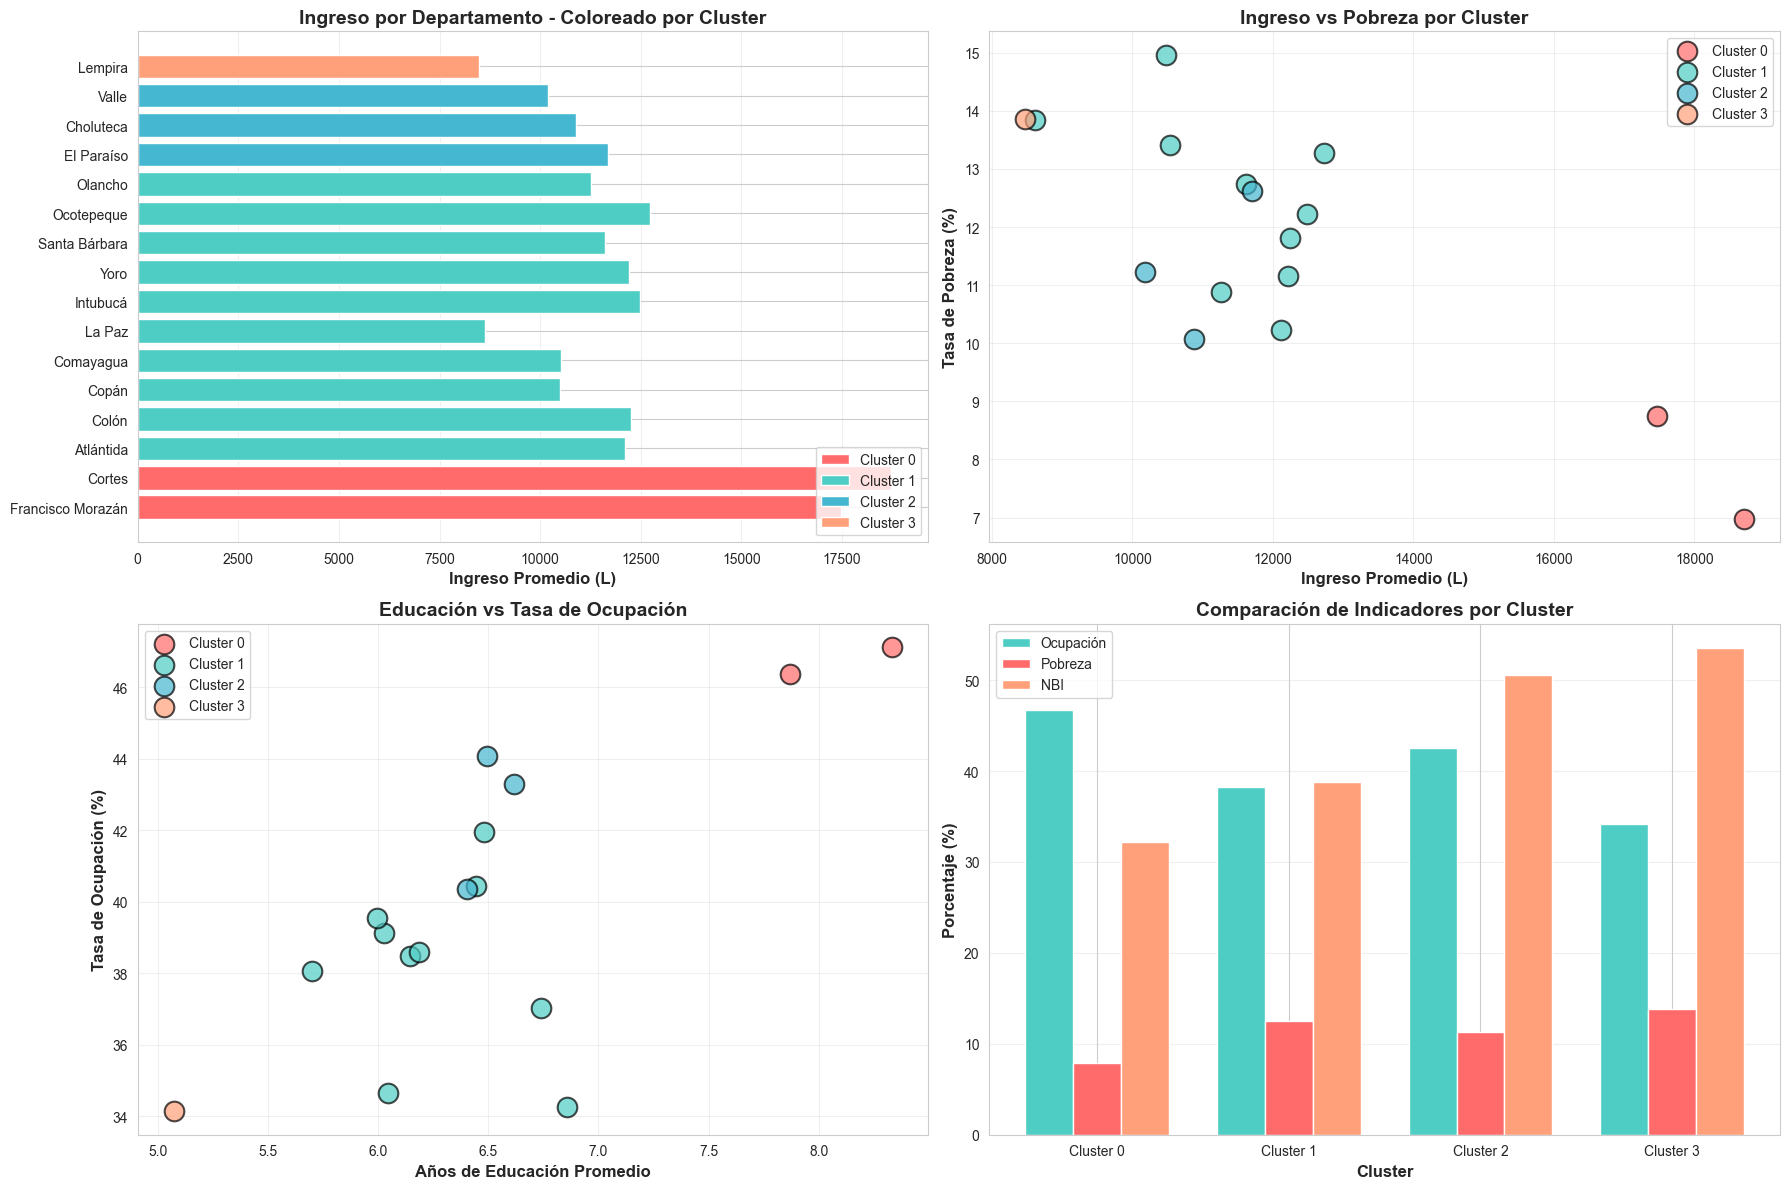

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Mapa de clusters (bar horizontal)
ax1 = axes[0, 0]
df_plot = df_depto.sort_values('cluster')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_colors = [colors[c] for c in df_plot['cluster']]

ax1.barh(df_plot['DEPTO'], df_plot['ymophg_mean'], color=cluster_colors)
ax1.set_xlabel('Ingreso Promedio (L)', fontsize=12, fontweight='bold')
ax1.set_title('Ingreso por Departamento - Coloreado por Cluster', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Leyenda de clusters
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {i}') for i in range(4)]
ax1.legend(handles=legend_elements, loc='lower right')

# 2. Scatter: Ingreso vs Pobreza
ax2 = axes[0, 1]
for i in range(4):
    cluster_data = df_depto[df_depto['cluster'] == i]
    ax2.scatter(cluster_data['ymophg_mean'], cluster_data['tasa_pobreza']*100, 
                c=colors[i], s=200, label=f'Cluster {i}', alpha=0.7, edgecolors='black', linewidth=1.5)

ax2.set_xlabel('Ingreso Promedio (L)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tasa de Pobreza (%)', fontsize=12, fontweight='bold')
ax2.set_title('Ingreso vs Pobreza por Cluster', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Educación vs Ocupación
ax3 = axes[1, 0]
for i in range(4):
    cluster_data = df_depto[df_depto['cluster'] == i]
    ax3.scatter(cluster_data['anosest_mean'], cluster_data['tasa_ocupacion']*100, 
                c=colors[i], s=200, label=f'Cluster {i}', alpha=0.7, edgecolors='black', linewidth=1.5)

ax3.set_xlabel('Años de Educación Promedio', fontsize=12, fontweight='bold')
ax3.set_ylabel('Tasa de Ocupación (%)', fontsize=12, fontweight='bold')
ax3.set_title('Educación vs Tasa de Ocupación', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Comparación de tasas por cluster
ax4 = axes[1, 1]
cluster_metrics = df_depto.groupby('cluster').agg({
    'tasa_ocupacion': 'mean',
    'tasa_pobreza': 'mean',
    'tasa_nbi': 'mean'
}).reset_index()

x = range(len(cluster_metrics))
width = 0.25

bars1 = ax4.bar([i - width for i in x], cluster_metrics['tasa_ocupacion']*100, 
                width, label='Ocupación', color='#4ECDC4')
bars2 = ax4.bar(x, cluster_metrics['tasa_pobreza']*100, 
                width, label='Pobreza', color='#FF6B6B')
bars3 = ax4.bar([i + width for i in x], cluster_metrics['tasa_nbi']*100, 
                width, label='NBI', color='#FFA07A')

ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax4.set_title('Comparación de Indicadores por Cluster', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f'Cluster {i}' for i in range(4)])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

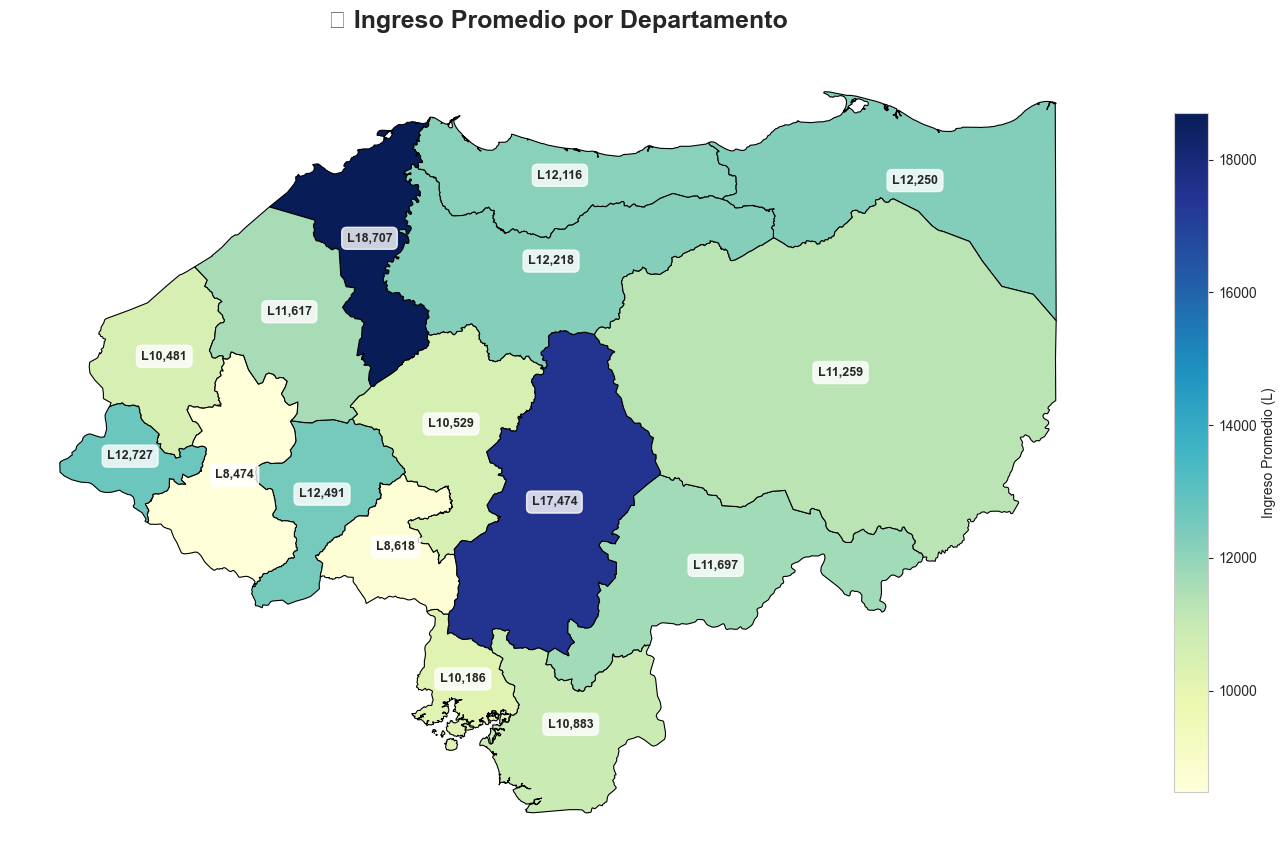

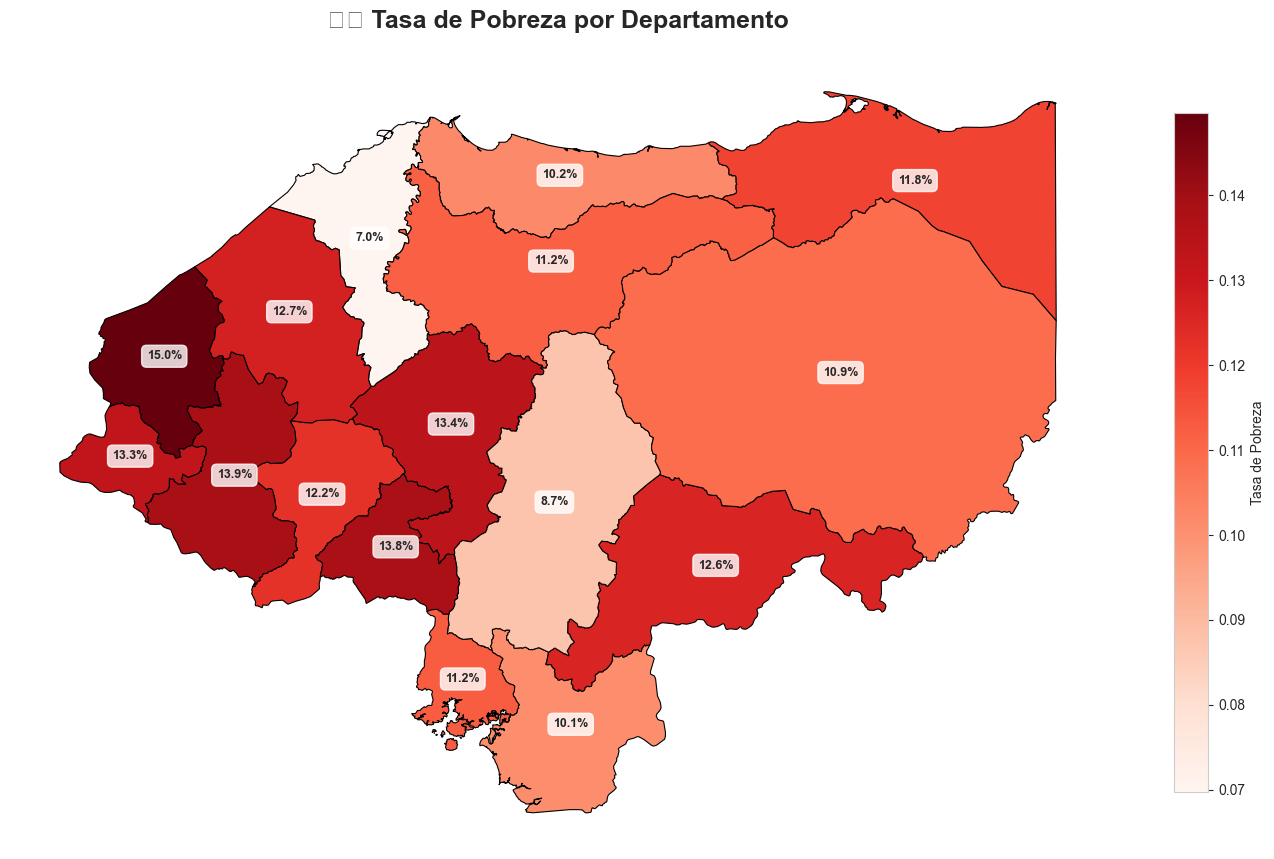

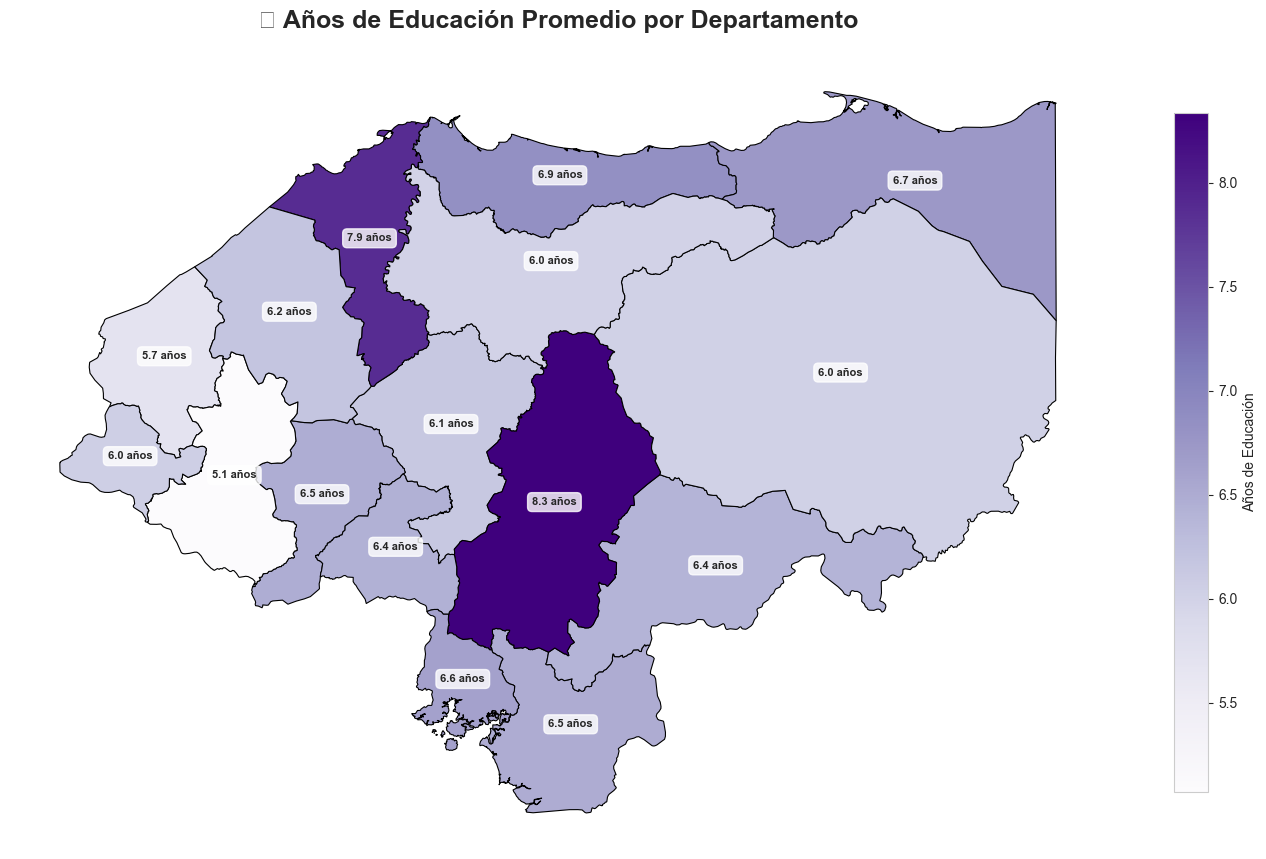

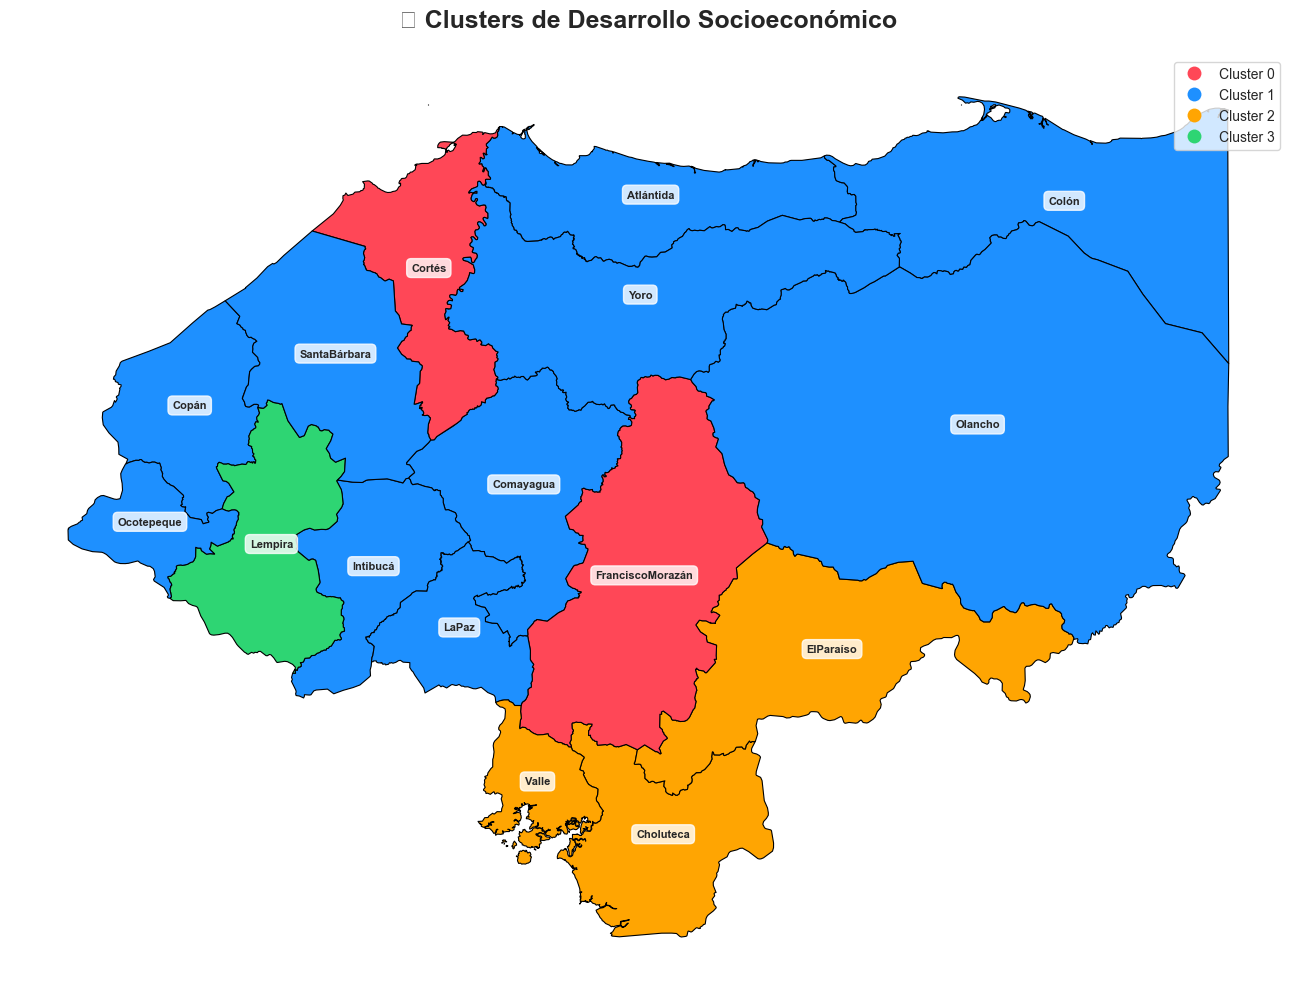

══════════════════════════════════════════════════════════════════════
📋 RESUMEN DEL ANÁLISIS SOCIOECONÓMICO
══════════════════════════════════════════════════════════════════════

✅ 16 de 18 departamentos con datos completos

🎯 DISTRIBUCIÓN POR CLUSTER:
──────────────────────────────────────────────────────────────────────
   Cluster 0: 2 depto(s) - Cortés, FranciscoMorazán
   Cluster 1: 10 depto(s) - Atlántida, Colón, Comayagua, Copán, Intibucá, LaPaz, Ocotepeque, Olancho, SantaBárbara, Yoro
   Cluster 2: 3 depto(s) - Choluteca, ElParaíso, Valle
   Cluster 3: 1 depto(s) - Lempira

💰 INDICADORES NACIONALES:
──────────────────────────────────────────────────────────────────────
   Ingreso promedio: L11,983
   Tasa de pobreza: 11.8%
   Educación promedio: 6.5 años
══════════════════════════════════════════════════════════════════════


In [12]:
# 🗺️ MAPAS CHOROPLETH - Datos Socioeconómicos por Departamento
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Cargar datos geográficos y normalizar nombres
gdf = gpd.read_file('data/gadm41_HND_1.json')

nombre_mapping = {
    'Atlántida': 'Atlántida', 'Choluteca': 'Choluteca', 'Colón': 'Colón',
    'Comayagua': 'Comayagua', 'Copán': 'Copán', 'Lempira': 'Lempira',
    'Ocotepeque': 'Ocotepeque', 'Olancho': 'Olancho', 'Valle': 'Valle', 'Yoro': 'Yoro',
    'Cortes': 'Cortés', 'El Paraíso': 'ElParaíso', 'Francisco Morazán': 'FranciscoMorazán',
    'Intubucá': 'Intibucá', 'La Paz': 'LaPaz', 'Santa Bárbara': 'SantaBárbara'
}

df_depto_norm = df_depto.copy()
df_depto_norm['DEPTO_NORM'] = df_depto_norm['DEPTO'].map(nombre_mapping)
gdf_merged = gdf.merge(df_depto_norm, left_on='NAME_1', right_on='DEPTO_NORM', how='left')

# Configuración de colores
colors_cluster = ['#FF4757', '#1E90FF', '#FFA502', '#2ED573']
cluster_cmap = ListedColormap(colors_cluster)

# ═══════════════════════════════════════════════════════════════════════
# MAPA 1: INGRESO PROMEDIO
# ═══════════════════════════════════════════════════════════════════════
fig1, ax1 = plt.subplots(figsize=(14, 10))
gdf_merged.plot(column='ymophg_mean', ax=ax1, legend=True, 
                cmap='YlGnBu', edgecolor='black', linewidth=0.8,
                legend_kwds={'label': 'Ingreso Promedio (L)', 'shrink': 0.7})
ax1.set_title('💰 Ingreso Promedio por Departamento', fontsize=18, fontweight='bold', pad=20)
ax1.axis('off')

for idx, row in gdf_merged.iterrows():
    if not pd.isnull(row['ymophg_mean']):
        centroid = row.geometry.centroid
        ax1.annotate(f"L{row['ymophg_mean']:,.0f}", 
                     xy=(centroid.x, centroid.y),
                     ha='center', fontsize=9, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════
# MAPA 2: TASA DE POBREZA
# ═══════════════════════════════════════════════════════════════════════
fig2, ax2 = plt.subplots(figsize=(14, 10))
gdf_merged.plot(column='tasa_pobreza', ax=ax2, legend=True,
                cmap='Reds', edgecolor='black', linewidth=0.8,
                legend_kwds={'label': 'Tasa de Pobreza', 'shrink': 0.7})
ax2.set_title('⚠️ Tasa de Pobreza por Departamento', fontsize=18, fontweight='bold', pad=20)
ax2.axis('off')

for idx, row in gdf_merged.iterrows():
    if not pd.isnull(row['tasa_pobreza']):
        centroid = row.geometry.centroid
        ax2.annotate(f"{row['tasa_pobreza']*100:.1f}%", 
                     xy=(centroid.x, centroid.y),
                     ha='center', fontsize=9, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════
# MAPA 3: AÑOS DE EDUCACIÓN
# ═══════════════════════════════════════════════════════════════════════
fig3, ax3 = plt.subplots(figsize=(14, 10))
gdf_merged.plot(column='anosest_mean', ax=ax3, legend=True,
                cmap='Purples', edgecolor='black', linewidth=0.8,
                legend_kwds={'label': 'Años de Educación', 'shrink': 0.7})
ax3.set_title('📚 Años de Educación Promedio por Departamento', fontsize=18, fontweight='bold', pad=20)
ax3.axis('off')

for idx, row in gdf_merged.iterrows():
    if not pd.isnull(row['anosest_mean']):
        centroid = row.geometry.centroid
        ax3.annotate(f"{row['anosest_mean']:.1f} años", 
                     xy=(centroid.x, centroid.y),
                     ha='center', fontsize=8, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════
# MAPA 4: CLUSTERS DE DESARROLLO
# ═══════════════════════════════════════════════════════════════════════
fig4, ax4 = plt.subplots(figsize=(14, 10))
gdf_merged.plot(column='cluster', ax=ax4, 
                cmap=cluster_cmap, edgecolor='black', linewidth=0.8,
                categorical=True, legend=True,
                legend_kwds={'labels': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], 
                            'loc': 'best'})
ax4.set_title('🎯 Clusters de Desarrollo Socioeconómico', fontsize=18, fontweight='bold', pad=20)
ax4.axis('off')

for idx, row in gdf_merged.iterrows():
    if not pd.isnull(row['cluster']):
        centroid = row.geometry.centroid
        ax4.annotate(row['NAME_1'], 
                     xy=(centroid.x, centroid.y),
                     ha='center', fontsize=8, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════
# RESUMEN ESTADÍSTICO
# ═══════════════════════════════════════════════════════════════════════
print("═"*70)
print("📋 RESUMEN DEL ANÁLISIS SOCIOECONÓMICO")
print("═"*70)
deptos_con_datos = gdf_merged['ymophg_mean'].notna().sum()
print(f"\n✅ {deptos_con_datos} de {len(gdf_merged)} departamentos con datos completos")

clusters_validos = gdf_merged[gdf_merged['cluster'].notna()]
print(f"\n🎯 DISTRIBUCIÓN POR CLUSTER:")
print("─"*70)
for cluster_id in sorted(clusters_validos['cluster'].unique()):
    deptos_cluster = clusters_validos[clusters_validos['cluster'] == cluster_id]['NAME_1'].tolist()
    print(f"   Cluster {int(cluster_id)}: {len(deptos_cluster)} depto(s) - {', '.join(deptos_cluster)}")

print(f"\n💰 INDICADORES NACIONALES:")
print("─"*70)
print(f"   Ingreso promedio: L{gdf_merged['ymophg_mean'].mean():,.0f}")
print(f"   Tasa de pobreza: {gdf_merged['tasa_pobreza'].mean()*100:.1f}%")
print(f"   Educación promedio: {gdf_merged['anosest_mean'].mean():.1f} años")
print("═"*70)

## 🗺️ Visualización de Datos en Mapas Departamentales

### 📊 Mapas Independientes Generados (4 ventanas):

1. **💰 Ingreso Promedio** - Choropleth con escala YlGnBu
   - Muestra el ingreso promedio por hogar (ymophg_mean)
   - Valores etiquetados en Lempiras directamente en el mapa
   - Colores más oscuros = mayores ingresos

2. **⚠️ Tasa de Pobreza** - Choropleth con escala de rojos
   - Porcentaje de población en situación de pobreza
   - Valores en porcentaje etiquetados en cada departamento
   - Rojo más intenso = mayor pobreza

3. **📚 Años de Educación** - Choropleth con escala morada
   - Promedio de años de educación (anosest_mean)
   - Muestra el nivel educativo promedio de la población
   - Morado más oscuro = mayor educación

4. **🎯 Clusters de Desarrollo** - Mapa categórico de 4 clusters
   - **Cluster 0** (Rojo): Desarrollo Alto
   - **Cluster 1** (Azul): Desarrollo Medio-Alto  
   - **Cluster 2** (Naranja): Desarrollo Medio-Bajo
   - **Cluster 3** (Verde): Desarrollo Bajo
   - Nombres de departamentos etiquetados directamente

### ✨ Características:
- **4 ventanas independientes** para mejor visualización
- **Mapas a tamaño completo** (14x10) para máxima legibilidad
- **Datos del modelo integrados** con geometrías GADM v4.1
- **Etiquetas directas** sin necesidad de interacción
- **16 departamentos** con datos completos (Gracias a Dios e Islas de la Bahía sin datos)

In [13]:
# Exportar modelo KMeans + Scaler a ONNX
import joblib
from sklearn.pipeline import Pipeline

# Crear un pipeline con el scaler + kmeans
clustering_pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', kmeans)
])

# Guardar el pipeline completo como .pkl (respaldo)
joblib.dump(clustering_pipeline, 'models/clustering_pipeline.pkl')
print("✅ Pipeline guardado como: models/clustering_pipeline.pkl")

# Guardar el scaler por separado (para uso individual)
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Scaler guardado como: models/scaler.pkl")

# Guardar el kmeans por separado
joblib.dump(kmeans, 'models/kmeans.pkl')
print("✅ KMeans guardado como: models/kmeans.pkl")

# También guardar información sobre las columnas usadas
feature_names = X.columns.tolist()
with open('models/feature_names.txt', 'w') as f:
    f.write(','.join(feature_names))
print(f"✅ Nombres de características guardados: {feature_names}")
print("\n" + "="*70)
print("Modelo listo para consumir desde FastAPI")
print("="*70)

✅ Pipeline guardado como: models/clustering_pipeline.pkl
✅ Scaler guardado como: models/scaler.pkl
✅ KMeans guardado como: models/kmeans.pkl
✅ Nombres de características guardados: ['ymophg_mean', 'ymophg_median', 'anosest_mean', 'edad_mean', 'totper_mean', 'tasa_ocupacion', 'tasa_pobreza', 'tasa_nbi']

Modelo listo para consumir desde FastAPI


In [14]:
# Convertir pipeline a ONNX
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import os

print("🔄 Convirtiendo modelo a ONNX...")
print("="*70)

# Definir el tipo de datos esperado
# 8 características (float), batch size variable
initial_type = [('float_input', FloatTensorType([None, 8]))]

# Convertir el pipeline a ONNX
try:
    onnx_model = convert_sklearn(
        clustering_pipeline, 
        initial_types=initial_type,
        target_opset={'': 15, 'ai.onnx.ml': 1}
    )
    
    # Si convert_sklearn retorna una tupla, obtener solo el modelo
    if isinstance(onnx_model, tuple):
        onnx_model = onnx_model[0]
    
    # Guardar el modelo ONNX
    onnx_path = 'models/clustering_model.onnx'
    with open(onnx_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())
    
    # Obtener tamaño
    pkl_size = os.path.getsize('models/clustering_pipeline.pkl') / (1024*1024)
    onnx_size = os.path.getsize(onnx_path) / (1024*1024)
    
    print(f"✅ Modelo ONNX guardado: models/clustering_model.onnx")
    print(f"\n📊 Comparación de tamaños:")
    print(f"   PKL:  {pkl_size:.2f} MB")
    print(f"   ONNX: {onnx_size:.2f} MB")
    print(f"   Reducción: {((pkl_size - onnx_size) / pkl_size * 100):.1f}%")
    
except Exception as e:
    print(f"❌ Error en conversión: {e}")
    print("   Asegúrate de tener scikit-learn >= 0.21 y skl2onnx instalado")

print("="*70)

🔄 Convirtiendo modelo a ONNX...
✅ Modelo ONNX guardado: models/clustering_model.onnx

📊 Comparación de tamaños:
   PKL:  0.00 MB
   ONNX: 0.00 MB
   Reducción: 53.4%
